In [1]:
import pdb
import os
import gc
import random
import glob
import sys
import random
import scipy.ndimage
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from imutils import paths
from itertools import chain, islice
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from keras.applications.inception_v3 import InceptionV3
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img

/home/aumkar/anaconda3/envs/daenv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:18: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
Using TensorFlow backend.


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
ROOT_DIR = os.path.normpath(os.path.join(os.path.dirname(os.path.realpath('__file__'))))
SOURCE_DIR = os.path.abspath('/data/aumkar/train')
TARGET_DIR = os.path.abspath('/data/aumkar/validation')
DATA_LOAD_DIR = os.path.abspath('/data/aumkar/data_load')

In [4]:
source_path = list(paths.list_images(SOURCE_DIR))
target_path = list(paths.list_images(TARGET_DIR))

labels_source = [p.split(os.path.sep)[-2] for p in source_path]
labels_target = [p.split(os.path.sep)[-2] for p in target_path]

In [5]:
classes = ['aeroplane', 'bicycle', 'bus', 'car', 'horse', 'knife', 'motorcycle', 'person', 'plant', 'skateboard', 
           'train', 'truck']

In [6]:
def paths_(label, path):
    
    return np.array([x for x in path if '%s' %label in x])

In [7]:
def data_count(x):
    
    xid, xcount = np.unique(x, return_counts=True)
    
    return xid, xcount

In [8]:
def get_data_min(label):
    
    id_, count = data_count(label)
    min_count = min(count)
    min_id = np.argmin(count)
    label_min = id_[min_id]
    
    return min_count, label_min

In [9]:
source_data = get_data_min(labels_source)
target_data = get_data_min(labels_target)

In [10]:
source_data

(7365, 'bicycle')

In [11]:
target_data

(2075, 'knife')

In [12]:
source_aeroplane = np.random.choice(paths_('aeroplane', source_path), size = source_data[0])
source_bicycle = paths_('bicycle', source_path)
source_bus = np.random.choice(paths_('bus', source_path), size = source_data[0])
source_car = np.random.choice(paths_('car', source_path), size = source_data[0])
source_horse = np.random.choice(paths_('horse', source_path), size = source_data[0])
source_knife = np.random.choice(paths_('knife', source_path), size = source_data[0])
source_motorcycle = np.random.choice(paths_('motorcycle', source_path), size = source_data[0])
source_person = np.random.choice(paths_('person', source_path), size = source_data[0])
source_plant = np.random.choice(paths_('plant', source_path), size = source_data[0])
source_skateboard = np.random.choice(paths_('skateboard', source_path), size = source_data[0])
source_train = np.random.choice(paths_('train/train', source_path), size = source_data[0])
source_truck = np.random.choice(paths_('truck', source_path), size = source_data[0])

In [13]:
source_path_ = list(chain(source_aeroplane, source_bicycle, source_bus, source_car, source_horse, source_knife, 
                     source_motorcycle, source_person, source_plant, source_skateboard, source_train, source_truck))

In [14]:
target_aeroplane = np.random.choice(paths_('aeroplane', target_path), size = target_data[0])
target_bicycle = np.random.choice(paths_('bicycle', target_path), size = target_data[0])
target_bus = np.random.choice(paths_('bus', target_path), size = target_data[0])
target_car = np.random.choice(paths_('car', target_path), size = target_data[0])
target_horse = np.random.choice(paths_('horse', target_path), size = target_data[0])
target_knife = paths_('knife', target_path)
target_motorcycle = np.random.choice(paths_('motorcycle', target_path), size = target_data[0])
target_person = np.random.choice(paths_('person', target_path), size = target_data[0])
target_plant = np.random.choice(paths_('plant', target_path), size = target_data[0])
target_skateboard = np.random.choice(paths_('skateboard', target_path), size = target_data[0])
target_train = np.random.choice(paths_('train', target_path), size = target_data[0])
target_truck = np.random.choice(paths_('truck', target_path), size = target_data[0])

In [15]:
target_path_ = list(chain(target_aeroplane, target_bicycle, target_bus, target_car, target_horse, target_knife, 
                     target_motorcycle, target_person, target_plant, target_skateboard, target_train, target_truck))

In [16]:
source_y = [p.split(os.path.sep)[-2] for p in source_path_]
target_y = [p.split(os.path.sep)[-2] for p in target_path_]

In [17]:
le = LabelEncoder()
labels = le.fit_transform(source_y)
labels_t = le.fit_transform(target_y)

In [18]:
len(source_path_), len(target_path_)

(88380, 24900)

In [19]:
labels.shape, labels_t.shape

((88380,), (24900,))

In [20]:
del source_y, target_y
gc.collect()

167

In [21]:
labels_unique = np.load(os.path.join(DATA_LOAD_DIR, 'labels.npy'))

In [22]:
clf = linear_model.SGDClassifier(max_iter = 1000, tol = 1e-4, n_jobs = -1, loss = 'log')

In [23]:
def model_create(transfer_model):
    if transfer_model == 'InceptionV3':
        with tf.device('/gpu:1'):
            return InceptionV3(weights = 'imagenet', include_top = False)
    elif transfer_model == 'VGG16':
        with tf.device('/gpu:1'):
            return VGG16(weights = 'imagenet', include_top = False)
    elif transfer_model == 'VGG19':
        with tf.device('/gpu:1'):
            return VGG19(weights = 'imagenet', include_top = False)
    elif transfer_model == 'Xception':
        with tf.device('/gpu:1'):
            return Xception(weights = 'imagenet', include_top = False)
    elif transfer_model == 'DenseNet121':
        with tf.device('/gpu:1'):
            return DenseNet121(weights = 'imagenet', include_top = False)

In [24]:
def model_reshape(transfer_model, features):
    if transfer_model == 'InceptionV3':
        return features.reshape((features.shape[0], 5 * 5 * 2048))
    elif transfer_model == 'VGG16':
        return features.reshape((features.shape[0], 7 * 7 * 512))
    elif transfer_model == 'VGG19':
        return features.reshape((features.shape[0], 7 * 7 * 512))
    elif transfer_model == 'Xception':
        return features.reshape((features.shape[0], 7 * 7 * 2048))
    elif transfer_model == 'DenseNet121':
        return features.reshape((features.shape[0], 7 * 7 * 1024))

In [25]:
def model_train(i, model, features, label):
    
    print('Training batch: ', i)
    model.partial_fit(features, label, classes = labels_unique)
       
    return model

In [26]:
def target_pred(model, target_features):
    
    #print('Predicting batch features')
    return model.predict(target_features)

In [27]:
step_size = 128

batches = int(len(source_path_) / step_size)
batches_target = int(len(target_path_) / step_size)

In [28]:
def source_batch_gen(batch, label):
    
    val = int(batch / len(classes))
        
    for batch in range(batches):
        
        if batch < (batches - 1):
            
            batch_aeroplane = source_aeroplane[batch * val: (batch + 1) * val]
            batch_bicycle = source_bicycle[batch * val: (batch + 1) * val]
            batch_bus = source_bus[batch * val: (batch + 1) * val]
            batch_car = source_car[batch * val: (batch + 1) * val]
            batch_horse = source_horse[batch * val: (batch + 1) * val]
            batch_knife = source_knife[batch * val: (batch + 1) * val]
            batch_motorcycle = source_motorcycle[batch * val: (batch + 1) * val]
            batch_person = source_person[batch * val: (batch + 1) * val]
            batch_plant = source_plant[batch * val: (batch + 1) * val]
            batch_skateboard = source_skateboard[batch * val: (batch + 1) * val]
            batch_train = source_train[batch * val: (batch + 1) * val]
            batch_truck = source_truck[batch * val: (batch + 1) * val]

            source_ = list(chain(batch_aeroplane, batch_bicycle, batch_bus, batch_car, batch_horse, batch_knife, 
                                 batch_motorcycle, batch_person, batch_plant, batch_skateboard, batch_train, batch_truck))

            aeroy = label[:7365]
            batch_aeroplane_y = aeroy[batch * val: (batch + 1) * val]

            biy = label[7365: 14730]
            batch_bicycle_y = biy[batch * val: (batch + 1) * val]

            busy = label[14730: 22095]
            batch_bus_y = busy[batch * val: (batch + 1) * val]

            cary = label[22095: 29460]
            batch_car_y = cary[batch * val: (batch + 1) * val]

            horsey = label[29460: 36825]
            batch_horse_y = horsey[batch * val: (batch + 1) * val]

            knifey = label[36825: 44190]
            batch_knife_y = knifey[batch * val: (batch + 1) * val]

            motory = label[44190: 51555]
            batch_motorcycle_y = motory[batch * val: (batch + 1) * val]

            pery = label[51555: 58920]
            batch_person_y = pery[batch * val: (batch + 1) * val]

            planty = label[58920: 66285]
            batch_plant_y = planty[batch * val: (batch + 1) * val]

            skatey = label[66285: 73650]
            batch_skateboard_y = skatey[batch * val: (batch + 1) * val]

            trainy = label[73650: 81015]
            batch_train_y = trainy[batch * val: (batch + 1) * val]

            trucky = label[81015:]
            batch_truck_y = trucky[batch * val: (batch + 1) * val]

            source_lab = list(chain(batch_aeroplane_y, batch_bicycle_y, batch_bus_y, batch_car_y, batch_horse_y, batch_knife_y, 
                                 batch_motorcycle_y, batch_person_y, batch_plant_y, batch_skateboard_y, batch_train_y, 
                                 batch_truck_y))


            yield (source_, source_lab)
            
        elif batch == (batches - 1):
            
            batch_aeroplane = source_aeroplane[batch * val:]
            batch_bicycle = source_bicycle[batch * val:]
            batch_bus = source_bus[batch * val:]
            batch_car = source_car[batch * val:]
            batch_horse = source_horse[batch * val:]
            batch_knife = source_knife[batch * val:]
            batch_motorcycle = source_motorcycle[batch * val:]
            batch_person = source_person[batch * val:]
            batch_plant = source_plant[batch * val:]
            batch_skateboard = source_skateboard[batch * val:]
            batch_train = source_train[batch * val:]
            batch_truck = source_truck[batch * val:]

            source_ = list(chain(batch_aeroplane, batch_bicycle, batch_bus, batch_car, batch_horse, batch_knife, 
                                 batch_motorcycle, batch_person, batch_plant, batch_skateboard, batch_train, batch_truck))

            aeroy = label[:7365]
            batch_aeroplane_y = aeroy[batch * val:]

            biy = label[7365: 14730]
            batch_bicycle_y = biy[batch * val:]

            busy = label[14730: 22095]
            batch_bus_y = busy[batch * val:]

            cary = label[22095: 29460]
            batch_car_y = cary[batch * val:]

            horsey = label[29460: 36825]
            batch_horse_y = horsey[batch * val:]

            knifey = label[36825: 44190]
            batch_knife_y = knifey[batch * val:]

            motory = label[44190: 51555]
            batch_motorcycle_y = motory[batch * val:]

            pery = label[51555: 58920]
            batch_person_y = pery[batch * val:]

            planty = label[58920: 66285]
            batch_plant_y = planty[batch * val:]

            skatey = label[66285: 73650]
            batch_skateboard_y = skatey[batch * val:]

            trainy = label[73650: 81015]
            batch_train_y = trainy[batch * val:]

            trucky = label[81015:]
            batch_truck_y = trucky[batch * val:]

            source_lab = list(chain(batch_aeroplane_y, batch_bicycle_y, batch_bus_y, batch_car_y, batch_horse_y, batch_knife_y, 
                                 batch_motorcycle_y, batch_person_y, batch_plant_y, batch_skateboard_y, batch_train_y, 
                                 batch_truck_y))


            yield (source_, source_lab)

In [29]:
def target_batch_gen(n, pred_): 
    
    val = int(n / len(classes))
    
    if type(pred_) == np.ndarray:
        pred1 = pred_.tolist()

    for batch in range(batches_target):
        
        if batch < (batches_target - 1):
            
            print('Target batch number for prediction: ', batch)
            batch_aeroplane = target_aeroplane[batch * val: (batch + 1) * val]
            batch_bicycle = target_bicycle[batch * val: (batch + 1) * val]
            batch_bus = target_bus[batch * val: (batch + 1) * val]
            batch_car = target_car[batch * val: (batch + 1) * val]
            batch_horse = target_horse[batch * val: (batch + 1) * val]
            batch_knife = target_knife[batch * val: (batch + 1) * val]
            batch_motorcycle = target_motorcycle[batch * val: (batch + 1) * val]
            batch_person = target_person[batch * val: (batch + 1) * val]
            batch_plant = target_plant[batch * val: (batch + 1) * val]
            batch_skateboard = target_skateboard[batch * val: (batch + 1) * val]
            batch_train = target_train[batch * val: (batch + 1) * val]
            batch_truck = target_truck[batch * val: (batch + 1) * val]

            target_ = list(chain(batch_aeroplane, batch_bicycle, batch_bus, batch_car, batch_horse, batch_knife, 
                                 batch_motorcycle, batch_person, batch_plant, batch_skateboard, batch_train, batch_truck))

            if type(pred_) == np.ndarray:
                aeroy = pred_[:2075]
                batch_aeroplane_y = aeroy[batch * val: (batch + 1) * val]

                biy = pred_[2075: 4150]
                batch_bicycle_y = biy[batch * val: (batch + 1) * val]

                busy = pred_[4150: 6225]
                batch_bus_y = busy[batch * val: (batch + 1) * val]

                cary = pred_[6225: 8300]
                batch_car_y = cary[batch * val: (batch + 1) * val]

                horsey = pred_[8300: 10375]
                batch_horse_y = horsey[batch * val: (batch + 1) * val]

                knifey = pred_[10375: 12450]
                batch_knife_y = knifey[batch * val: (batch + 1) * val]

                motory = pred_[12450: 14525]
                batch_motorcycle_y = motory[batch * val: (batch + 1) * val]

                pery = pred_[14525: 16600]
                batch_person_y = pery[batch * val: (batch + 1) * val]

                planty = pred_[16600: 18675]
                batch_plant_y = planty[batch * val: (batch + 1) * val]

                skatey = pred_[18675: 20750]
                batch_skateboard_y = skatey[batch * val: (batch + 1) * val]

                trainy = pred_[20750: 22825]
                batch_train_y = trainy[batch * val: (batch + 1) * val]

                trucky = pred_[22825:]
                batch_truck_y = trucky[batch * val: (batch + 1) * val]

                target_lab = list(chain(batch_aeroplane_y, batch_bicycle_y, batch_bus_y, batch_car_y, batch_horse_y, batch_knife_y, 
                                     batch_motorcycle_y, batch_person_y, batch_plant_y, batch_skateboard_y, batch_train_y, 
                                     batch_truck_y))


                yield (target_, target_lab)

            elif pred_ == None:
                yield target_
                
        
        if batch == (batches_target - 1):
            
            print('Target batch number for prediction: ', batch)
            batch_aeroplane = target_aeroplane[batch * val:]
            batch_bicycle = target_bicycle[batch * val:]
            batch_bus = target_bus[batch * val:]
            batch_car = target_car[batch * val:]
            batch_horse = target_horse[batch * val:]
            batch_knife = target_knife[batch * val:]
            batch_motorcycle = target_motorcycle[batch * val:]
            batch_person = target_person[batch * val:]
            batch_plant = target_plant[batch * val:]
            batch_skateboard = target_skateboard[batch * val:]
            batch_train = target_train[batch * val:]
            batch_truck = target_truck[batch * val:]

            target_ = list(chain(batch_aeroplane, batch_bicycle, batch_bus, batch_car, batch_horse, batch_knife, 
                                 batch_motorcycle, batch_person, batch_plant, batch_skateboard, batch_train, batch_truck))

            if type(pred_) == np.ndarray:
                aeroy = pred_[:2075]
                batch_aeroplane_y = aeroy[batch * val:]

                biy = pred_[2075: 4150]
                batch_bicycle_y = biy[batch * val:]

                busy = pred_[4150: 6225]
                batch_bus_y = busy[batch * val:]

                cary = pred_[6225: 8300]
                batch_car_y = cary[batch * val:]

                horsey = pred_[8300: 10375]
                batch_horse_y = horsey[batch * val:]

                knifey = pred_[10375: 12450]
                batch_knife_y = knifey[batch * val:]

                motory = pred_[12450: 14525]
                batch_motorcycle_y = motory[batch * val:]

                pery = pred_[14525: 16600]
                batch_person_y = pery[batch * val:]

                planty = pred_[16600: 18675]
                batch_plant_y = planty[batch * val:]

                skatey = pred_[18675: 20750]
                batch_skateboard_y = skatey[batch * val:]

                trainy = pred_[20750: 22825]
                batch_train_y = trainy[batch * val:]

                trucky = pred_[22825:]
                batch_truck_y = trucky[batch * val:]

                target_lab = list(chain(batch_aeroplane_y, batch_bicycle_y, batch_bus_y, batch_car_y, batch_horse_y, batch_knife_y, 
                                     batch_motorcycle_y, batch_person_y, batch_plant_y, batch_skateboard_y, batch_train_y, 
                                     batch_truck_y))


                yield (target_, target_lab)

            elif pred_ == None:
                yield target_

In [30]:
def target_sample_extract(n, pred_):
    
    val = int(n / len(classes))
    
    if type(pred_) == np.ndarray:
        pred1 = pred_.tolist()
        
    batch_aeroplane = target_aeroplane[:val]
    batch_bicycle = target_bicycle[:val]
    batch_bus = target_bus[:val]
    batch_car = target_car[:val]
    batch_horse = target_horse[:val]
    batch_knife = target_knife[:val]
    batch_motorcycle = target_motorcycle[:val]
    batch_person = target_person[:val]
    batch_plant = target_plant[:val]
    batch_skateboard = target_skateboard[:val]
    batch_train = target_train[:val]
    batch_truck = target_truck[:val]
    
    target_ = list(chain(batch_aeroplane, batch_bicycle, batch_bus, batch_car, batch_horse, batch_knife, 
                                 batch_motorcycle, batch_person, batch_plant, batch_skateboard, batch_train, batch_truck))
    
    aeroy = pred_[:2075]
    batch_aeroplane_y = aeroy[:val]

    biy = pred_[2075: 4150]
    batch_bicycle_y = biy[:val]

    busy = pred_[4150: 6225]
    batch_bus_y = busy[:val]

    cary = pred_[6225: 8300]
    batch_car_y = cary[:val]

    horsey = pred_[8300: 10375]
    batch_horse_y = horsey[:val]

    knifey = pred_[10375: 12450]
    batch_knife_y = knifey[:val]

    motory = pred_[12450: 14525]
    batch_motorcycle_y = motory[:val]

    pery = pred_[14525: 16600]
    batch_person_y = pery[:val]

    planty = pred_[16600: 18675]
    batch_plant_y = planty[:val]

    skatey = pred_[18675: 20750]
    batch_skateboard_y = skatey[:val]

    trainy = pred_[20750: 22825]
    batch_train_y = trainy[:val]

    trucky = pred_[22825:]
    batch_truck_y = trucky[:val]
    
    target_lab = list(chain(batch_aeroplane_y, batch_bicycle_y, batch_bus_y, batch_car_y, batch_horse_y, batch_knife_y, 
                            batch_motorcycle_y, batch_person_y, batch_plant_y, batch_skateboard_y, batch_train_y, 
                            batch_truck_y))
    
    assert(len(target_) == len(target_lab))
    
    del batch_aeroplane, batch_bicycle, batch_bus, batch_car, batch_horse, batch_knife, batch_motorcycle, batch_person, 
    batch_plant, batch_skateboard, batch_train, batch_truck, batch_aeroplane_y, batch_bicycle_y, batch_bus_y, batch_car_y, 
    batch_horse_y, batch_knife_y, batch_motorcycle_y, batch_person_y, batch_plant_y, batch_skateboard_y, batch_train_y, 
    batch_truck_y
    
    gc.collect()
    
    return target_, target_lab

In [31]:
def feature_train(batchPaths, model1, model_, source, iteration, b, model_partial, batchLabels):
    
    batchImages = []
    #print(len(batchPaths))
    for imagePath in batchPaths:

        image = load_img(imagePath, target_size=(224, 224))
        image = img_to_array(image)

        image = np.expand_dims(image, axis=0)
        image = imagenet_utils.preprocess_input(image)

        batchImages.append(image)

    batchImages = np.vstack(batchImages)

    features = model1.predict(batchImages, batch_size = step_size)
    features1 = model_reshape(model_, features)
    
    del image, batchImages
    gc.collect()

    if source == 'source' and b == 0:
        return model_train(b, clf, features1, batchLabels)
    elif source == 'source' and b != 0:
        return model_train(b, model_partial, features1, batchLabels)
    elif source == 'target' and iteration == 0:
        return target_pred(model_partial, features1)
    elif source == 'target' and b == 0 and iteration != 0:
        return model_train(b, clf, features1, batchLabels)
    elif source == 'target' and b != 0 and iteration != 0:
        return model_train(b, model_partial, features1, batchLabels)

In [32]:
def feature_extract(batch_size, pseudo_labels, source_labels, model_, source, trained_model, iteration, n_k):
    
    pred = []
    s_path = []
    
    model1 = model_create(model_)

    if source == 'target' and iteration == 0:
        
        for target_sample in target_batch_gen(batch_size, None):

                pred.append(feature_train(target_sample, model1, model_, source, iteration, None, trained_model, None))
    
    elif trained_model == None and n_k == None:
        
        b = 0
        
        for batchPaths, source_labels_ in source_batch_gen(batch_size, source_labels):
            
            batchLabels = np.array(source_labels_)
            
            if b == 0:
                model_partial = feature_train(batchPaths, model1, model_, source, iteration, b, None, batchLabels)
            else:
                model_partial = feature_train(batchPaths, model1, model_, source, iteration, b, model_partial, batchLabels)

            b += 1

    elif source == 'target' and iteration != 0:   
        
        target_sample, labels_sample = target_sample_extract(n_k, pseudo_labels)
        
        b = 0
        
        for batchPaths, source_labels_ in source_batch_gen(batch_size, source_labels):
            
            assert(len(batchPaths) == len(source_labels_))
            
            if b == 0:
                
                batch_path = list(chain(batchPaths, target_sample))
                slabels = list(chain(source_labels_, labels_sample))
                batchLabels = np.array(slabels)
                
                assert(len(batch_path) == len(batchLabels))
                
                model_partial = feature_train(batch_path, model1, model_, source, iteration, b, None, batchLabels)
                
                b += 1
                
            elif b != 0:

                batchLabels = np.array(source_labels_)
                model_partial = feature_train(batchPaths, model1, model_, source, iteration, b, model_partial, batchLabels)
                
                b += 1

    del model1
    gc.collect()
    
    if source == 'target' and iteration != 0:
        return model_partial
    if source == 'source' and iteration == 0:
        return model_partial
    elif source == 'target' and iteration == 0:
        return np.hstack(np.asarray(pred))

In [33]:
def sslda_online(M):
    
    score = []
    
    svm_model = feature_extract(step_size, None, labels, 'InceptionV3', 'source', None, 0, None)
    
    target_predictions = feature_extract(step_size, None, labels_t, 'InceptionV3', 'target', svm_model, 0, None)
    
    print(classification_report(labels_t, target_predictions, target_names = classes))

    for i in range(1, M):
        
        print('Iteration: ', i)
         
        n = (i / float(M)) * len(target_path_)
        
        if i == 1:
            mod = feature_extract(step_size, target_predictions, labels, 'InceptionV3', 'target', None, i, n)
            fin_pred = feature_extract(step_size, None, labels_t, 'InceptionV3', 'target', mod, 0, None)
        else:
            mod = feature_extract(step_size, fin_pred, labels, 'InceptionV3', 'target', None, i, n)
            fin_pred = feature_extract(step_size, None, labels_t, 'InceptionV3', 'target', mod, 0, None)
        
        score.append(accuracy_score(labels_t, fin_pred))
    
    del svm_model, target_predictions, mod
    gc.collect()
    
    return fin_pred, score

In [34]:
def ensemble_sslda():
    
    pred = []
    mean_acc = []

    for i in range(5):

        print('ENSEMBLE ITERATION: ', i+1)

        sslda_pred, acc = sslda_online(3)

        pred.append(sslda_pred)
        mean_acc.append(acc)
        
        print(classification_report(labels_t, pred[-1], target_names = classes))
        
    return pred, mean_acc

In [35]:
pred, mean_acc = ensemble_sslda()

ENSEMBLE ITERATION:  1
Instructions for updating:
Colocations handled automatically by placer.
Training batch:  0
Training batch:  1
Training batch:  2
Training batch:  3
Training batch:  4
Training batch:  5
Training batch:  6
Training batch:  7
Training batch:  8
Training batch:  9
Training batch:  10
Training batch:  11
Training batch:  12
Training batch:  13
Training batch:  14
Training batch:  15
Training batch:  16
Training batch:  17
Training batch:  18
Training batch:  19
Training batch:  20
Training batch:  21
Training batch:  22
Training batch:  23
Training batch:  24
Training batch:  25
Training batch:  26
Training batch:  27
Training batch:  28
Training batch:  29
Training batch:  30
Training batch:  31
Training batch:  32
Training batch:  33
Training batch:  34
Training batch:  35
Training batch:  36
Training batch:  37
Training batch:  38
Training batch:  39
Training batch:  40
Training batch:  41
Training batch:  42
Training batch:  43
Training batch:  44
Training batch:

Training batch:  380
Training batch:  381
Training batch:  382
Training batch:  383
Training batch:  384
Training batch:  385
Training batch:  386
Training batch:  387
Training batch:  388
Training batch:  389
Training batch:  390
Training batch:  391
Training batch:  392
Training batch:  393
Training batch:  394
Training batch:  395
Training batch:  396
Training batch:  397
Training batch:  398
Training batch:  399
Training batch:  400
Training batch:  401
Training batch:  402
Training batch:  403
Training batch:  404
Training batch:  405
Training batch:  406
Training batch:  407
Training batch:  408
Training batch:  409
Training batch:  410
Training batch:  411
Training batch:  412
Training batch:  413
Training batch:  414
Training batch:  415
Training batch:  416
Training batch:  417
Training batch:  418
Training batch:  419
Training batch:  420
Training batch:  421
Training batch:  422
Training batch:  423
Training batch:  424
Training batch:  425
Training batch:  426
Training batc

Target batch number for prediction:  43
Target batch number for prediction:  44
Target batch number for prediction:  45
Target batch number for prediction:  46
Target batch number for prediction:  47
Target batch number for prediction:  48
Target batch number for prediction:  49
Target batch number for prediction:  50
Target batch number for prediction:  51
Target batch number for prediction:  52
Target batch number for prediction:  53
Target batch number for prediction:  54
Target batch number for prediction:  55
Target batch number for prediction:  56
Target batch number for prediction:  57
Target batch number for prediction:  58
Target batch number for prediction:  59
Target batch number for prediction:  60
Target batch number for prediction:  61
Target batch number for prediction:  62
Target batch number for prediction:  63
Target batch number for prediction:  64
Target batch number for prediction:  65
Target batch number for prediction:  66
Target batch number for prediction:  67


Training batch:  66
Training batch:  67
Training batch:  68
Training batch:  69
Training batch:  70
Training batch:  71
Training batch:  72
Training batch:  73
Training batch:  74
Training batch:  75
Training batch:  76
Training batch:  77
Training batch:  78
Training batch:  79
Training batch:  80
Training batch:  81
Training batch:  82
Training batch:  83
Training batch:  84
Training batch:  85
Training batch:  86
Training batch:  87
Training batch:  88
Training batch:  89
Training batch:  90
Training batch:  91
Training batch:  92
Training batch:  93
Training batch:  94
Training batch:  95
Training batch:  96
Training batch:  97
Training batch:  98
Training batch:  99
Training batch:  100
Training batch:  101
Training batch:  102
Training batch:  103
Training batch:  104
Training batch:  105
Training batch:  106
Training batch:  107
Training batch:  108
Training batch:  109
Training batch:  110
Training batch:  111
Training batch:  112
Training batch:  113
Training batch:  114
Train

Training batch:  458
Training batch:  459
Training batch:  460
Training batch:  461
Training batch:  462
Training batch:  463
Training batch:  464
Training batch:  465
Training batch:  466
Training batch:  467
Training batch:  468
Training batch:  469
Training batch:  470
Training batch:  471
Training batch:  472
Training batch:  473
Training batch:  474
Training batch:  475
Training batch:  476
Training batch:  477
Training batch:  478
Training batch:  479
Training batch:  480
Training batch:  481
Training batch:  482
Training batch:  483
Training batch:  484
Training batch:  485
Training batch:  486
Training batch:  487
Training batch:  488
Training batch:  489
Training batch:  490
Training batch:  491
Training batch:  492
Training batch:  493
Training batch:  494
Training batch:  495
Training batch:  496
Training batch:  497
Training batch:  498
Training batch:  499
Training batch:  500
Training batch:  501
Training batch:  502
Training batch:  503
Training batch:  504
Training batc

Target batch number for prediction:  84
Target batch number for prediction:  85
Target batch number for prediction:  86
Target batch number for prediction:  87
Target batch number for prediction:  88
Target batch number for prediction:  89
Target batch number for prediction:  90
Target batch number for prediction:  91
Target batch number for prediction:  92
Target batch number for prediction:  93
Target batch number for prediction:  94
Target batch number for prediction:  95
Target batch number for prediction:  96
Target batch number for prediction:  97
Target batch number for prediction:  98
Target batch number for prediction:  99
Target batch number for prediction:  100
Target batch number for prediction:  101
Target batch number for prediction:  102
Target batch number for prediction:  103
Target batch number for prediction:  104
Target batch number for prediction:  105
Target batch number for prediction:  106
Target batch number for prediction:  107
Target batch number for predicti

Training batch:  181
Training batch:  182
Training batch:  183
Training batch:  184
Training batch:  185
Training batch:  186
Training batch:  187
Training batch:  188
Training batch:  189
Training batch:  190
Training batch:  191
Training batch:  192
Training batch:  193
Training batch:  194
Training batch:  195
Training batch:  196
Training batch:  197
Training batch:  198
Training batch:  199
Training batch:  200
Training batch:  201
Training batch:  202
Training batch:  203
Training batch:  204
Training batch:  205
Training batch:  206
Training batch:  207
Training batch:  208
Training batch:  209
Training batch:  210
Training batch:  211
Training batch:  212
Training batch:  213
Training batch:  214
Training batch:  215
Training batch:  216
Training batch:  217
Training batch:  218
Training batch:  219
Training batch:  220
Training batch:  221
Training batch:  222
Training batch:  223
Training batch:  224
Training batch:  225
Training batch:  226
Training batch:  227
Training batc

Training batch:  572
Training batch:  573
Training batch:  574
Training batch:  575
Training batch:  576
Training batch:  577
Training batch:  578
Training batch:  579
Training batch:  580
Training batch:  581
Training batch:  582
Training batch:  583
Training batch:  584
Training batch:  585
Training batch:  586
Training batch:  587
Training batch:  588
Training batch:  589
Training batch:  590
Training batch:  591
Training batch:  592
Training batch:  593
Training batch:  594
Training batch:  595
Training batch:  596
Training batch:  597
Training batch:  598
Training batch:  599
Training batch:  600
Training batch:  601
Training batch:  602
Training batch:  603
Training batch:  604
Training batch:  605
Training batch:  606
Training batch:  607
Training batch:  608
Training batch:  609
Training batch:  610
Training batch:  611
Training batch:  612
Training batch:  613
Training batch:  614
Training batch:  615
Training batch:  616
Training batch:  617
Training batch:  618
Training batc

Target batch number for prediction:  143
Target batch number for prediction:  144
Target batch number for prediction:  145
Target batch number for prediction:  146
Target batch number for prediction:  147
Target batch number for prediction:  148
Target batch number for prediction:  149
Target batch number for prediction:  150
Target batch number for prediction:  151
Target batch number for prediction:  152
Target batch number for prediction:  153
Target batch number for prediction:  154
Target batch number for prediction:  155
Target batch number for prediction:  156
Target batch number for prediction:  157
Target batch number for prediction:  158
Target batch number for prediction:  159
Target batch number for prediction:  160
Target batch number for prediction:  161
Target batch number for prediction:  162
Target batch number for prediction:  163
Target batch number for prediction:  164
Target batch number for prediction:  165
Target batch number for prediction:  166
Target batch num

Training batch:  260
Training batch:  261
Training batch:  262
Training batch:  263
Training batch:  264
Training batch:  265
Training batch:  266
Training batch:  267
Training batch:  268
Training batch:  269
Training batch:  270
Training batch:  271
Training batch:  272
Training batch:  273
Training batch:  274
Training batch:  275
Training batch:  276
Training batch:  277
Training batch:  278
Training batch:  279
Training batch:  280
Training batch:  281
Training batch:  282
Training batch:  283
Training batch:  284
Training batch:  285
Training batch:  286
Training batch:  287
Training batch:  288
Training batch:  289
Training batch:  290
Training batch:  291
Training batch:  292
Training batch:  293
Training batch:  294
Training batch:  295
Training batch:  296
Training batch:  297
Training batch:  298
Training batch:  299
Training batch:  300
Training batch:  301
Training batch:  302
Training batch:  303
Training batch:  304
Training batch:  305
Training batch:  306
Training batc

Training batch:  651
Training batch:  652
Training batch:  653
Training batch:  654
Training batch:  655
Training batch:  656
Training batch:  657
Training batch:  658
Training batch:  659
Training batch:  660
Training batch:  661
Training batch:  662
Training batch:  663
Training batch:  664
Training batch:  665
Training batch:  666
Training batch:  667
Training batch:  668
Training batch:  669
Training batch:  670
Training batch:  671
Training batch:  672
Training batch:  673
Training batch:  674
Training batch:  675
Training batch:  676
Training batch:  677
Training batch:  678
Training batch:  679
Training batch:  680
Training batch:  681
Training batch:  682
Training batch:  683
Training batch:  684
Training batch:  685
Training batch:  686
Training batch:  687
Training batch:  688
Training batch:  689
Target batch number for prediction:  0
Target batch number for prediction:  1
Target batch number for prediction:  2
Target batch number for prediction:  3
Target batch number for p

Target batch number for prediction:  183
Target batch number for prediction:  184
Target batch number for prediction:  185
Target batch number for prediction:  186
Target batch number for prediction:  187
Target batch number for prediction:  188
Target batch number for prediction:  189
Target batch number for prediction:  190
Target batch number for prediction:  191
Target batch number for prediction:  192
Target batch number for prediction:  193
             precision    recall  f1-score   support

  aeroplane       0.09      0.05      0.06      2075
    bicycle       0.08      0.05      0.06      2075
        bus       0.09      0.06      0.07      2075
        car       0.08      0.28      0.13      2075
      horse       0.14      0.00      0.01      2075
      knife       0.10      0.00      0.00      2075
 motorcycle       0.08      0.19      0.12      2075
     person       0.12      0.00      0.00      2075
      plant       0.10      0.01      0.01      2075
 skateboard       

Training batch:  338
Training batch:  339
Training batch:  340
Training batch:  341
Training batch:  342
Training batch:  343
Training batch:  344
Training batch:  345
Training batch:  346
Training batch:  347
Training batch:  348
Training batch:  349
Training batch:  350
Training batch:  351
Training batch:  352
Training batch:  353
Training batch:  354
Training batch:  355
Training batch:  356
Training batch:  357
Training batch:  358
Training batch:  359
Training batch:  360
Training batch:  361
Training batch:  362
Training batch:  363
Training batch:  364
Training batch:  365
Training batch:  366
Training batch:  367
Training batch:  368
Training batch:  369
Training batch:  370
Training batch:  371
Training batch:  372
Training batch:  373
Training batch:  374
Training batch:  375
Training batch:  376
Training batch:  377
Training batch:  378
Training batch:  379
Training batch:  380
Training batch:  381
Training batch:  382
Training batch:  383
Training batch:  384
Training batc

Target batch number for prediction:  21
Target batch number for prediction:  22
Target batch number for prediction:  23
Target batch number for prediction:  24
Target batch number for prediction:  25
Target batch number for prediction:  26
Target batch number for prediction:  27
Target batch number for prediction:  28
Target batch number for prediction:  29
Target batch number for prediction:  30
Target batch number for prediction:  31
Target batch number for prediction:  32
Target batch number for prediction:  33
Target batch number for prediction:  34
Target batch number for prediction:  35
Target batch number for prediction:  36
Target batch number for prediction:  37
Target batch number for prediction:  38
Target batch number for prediction:  39
Target batch number for prediction:  40
Target batch number for prediction:  41
Target batch number for prediction:  42
Target batch number for prediction:  43
Target batch number for prediction:  44
Target batch number for prediction:  45


Training batch:  59
Training batch:  60
Training batch:  61
Training batch:  62
Training batch:  63
Training batch:  64
Training batch:  65
Training batch:  66
Training batch:  67
Training batch:  68
Training batch:  69
Training batch:  70
Training batch:  71
Training batch:  72
Training batch:  73
Training batch:  74
Training batch:  75
Training batch:  76
Training batch:  77
Training batch:  78
Training batch:  79
Training batch:  80
Training batch:  81
Training batch:  82
Training batch:  83
Training batch:  84
Training batch:  85
Training batch:  86
Training batch:  87
Training batch:  88
Training batch:  89
Training batch:  90
Training batch:  91
Training batch:  92
Training batch:  93
Training batch:  94
Training batch:  95
Training batch:  96
Training batch:  97
Training batch:  98
Training batch:  99
Training batch:  100
Training batch:  101
Training batch:  102
Training batch:  103
Training batch:  104
Training batch:  105
Training batch:  106
Training batch:  107
Training bat

Training batch:  452
Training batch:  453
Training batch:  454
Training batch:  455
Training batch:  456
Training batch:  457
Training batch:  458
Training batch:  459
Training batch:  460
Training batch:  461
Training batch:  462
Training batch:  463
Training batch:  464
Training batch:  465
Training batch:  466
Training batch:  467
Training batch:  468
Training batch:  469
Training batch:  470
Training batch:  471
Training batch:  472
Training batch:  473
Training batch:  474
Training batch:  475
Training batch:  476
Training batch:  477
Training batch:  478
Training batch:  479
Training batch:  480
Training batch:  481
Training batch:  482
Training batch:  483
Training batch:  484
Training batch:  485
Training batch:  486
Training batch:  487
Training batch:  488
Training batch:  489
Training batch:  490
Training batch:  491
Training batch:  492
Training batch:  493
Training batch:  494
Training batch:  495
Training batch:  496
Training batch:  497
Training batch:  498
Training batc

Target batch number for prediction:  81
Target batch number for prediction:  82
Target batch number for prediction:  83
Target batch number for prediction:  84
Target batch number for prediction:  85
Target batch number for prediction:  86
Target batch number for prediction:  87
Target batch number for prediction:  88
Target batch number for prediction:  89
Target batch number for prediction:  90
Target batch number for prediction:  91
Target batch number for prediction:  92
Target batch number for prediction:  93
Target batch number for prediction:  94
Target batch number for prediction:  95
Target batch number for prediction:  96
Target batch number for prediction:  97
Target batch number for prediction:  98
Target batch number for prediction:  99
Target batch number for prediction:  100
Target batch number for prediction:  101
Target batch number for prediction:  102
Target batch number for prediction:  103
Target batch number for prediction:  104
Target batch number for prediction:

Training batch:  140
Training batch:  141
Training batch:  142
Training batch:  143
Training batch:  144
Training batch:  145
Training batch:  146
Training batch:  147
Training batch:  148
Training batch:  149
Training batch:  150
Training batch:  151
Training batch:  152
Training batch:  153
Training batch:  154
Training batch:  155
Training batch:  156
Training batch:  157
Training batch:  158
Training batch:  159
Training batch:  160
Training batch:  161
Training batch:  162
Training batch:  163
Training batch:  164
Training batch:  165
Training batch:  166
Training batch:  167
Training batch:  168
Training batch:  169
Training batch:  170
Training batch:  171
Training batch:  172
Training batch:  173
Training batch:  174
Training batch:  175
Training batch:  176
Training batch:  177
Training batch:  178
Training batch:  179
Training batch:  180
Training batch:  181
Training batch:  182
Training batch:  183
Training batch:  184
Training batch:  185
Training batch:  186
Training batc

Training batch:  531
Training batch:  532
Training batch:  533
Training batch:  534
Training batch:  535
Training batch:  536
Training batch:  537
Training batch:  538
Training batch:  539
Training batch:  540
Training batch:  541
Training batch:  542
Training batch:  543
Training batch:  544
Training batch:  545
Training batch:  546
Training batch:  547
Training batch:  548
Training batch:  549
Training batch:  550
Training batch:  551
Training batch:  552
Training batch:  553
Training batch:  554
Training batch:  555
Training batch:  556
Training batch:  557
Training batch:  558
Training batch:  559
Training batch:  560
Training batch:  561
Training batch:  562
Training batch:  563
Training batch:  564
Training batch:  565
Training batch:  566
Training batch:  567
Training batch:  568
Training batch:  569
Training batch:  570
Training batch:  571
Training batch:  572
Training batch:  573
Training batch:  574
Training batch:  575
Training batch:  576
Training batch:  577
Training batc

Target batch number for prediction:  122
Target batch number for prediction:  123
Target batch number for prediction:  124
Target batch number for prediction:  125
Target batch number for prediction:  126
Target batch number for prediction:  127
Target batch number for prediction:  128
Target batch number for prediction:  129
Target batch number for prediction:  130
Target batch number for prediction:  131
Target batch number for prediction:  132
Target batch number for prediction:  133
Target batch number for prediction:  134
Target batch number for prediction:  135
Target batch number for prediction:  136
Target batch number for prediction:  137
Target batch number for prediction:  138
Target batch number for prediction:  139
Target batch number for prediction:  140
Target batch number for prediction:  141
Target batch number for prediction:  142
Target batch number for prediction:  143
Target batch number for prediction:  144
Target batch number for prediction:  145
Target batch num

Training batch:  219
Training batch:  220
Training batch:  221
Training batch:  222
Training batch:  223
Training batch:  224
Training batch:  225
Training batch:  226
Training batch:  227
Training batch:  228
Training batch:  229
Training batch:  230
Training batch:  231
Training batch:  232
Training batch:  233
Training batch:  234
Training batch:  235
Training batch:  236
Training batch:  237
Training batch:  238
Training batch:  239
Training batch:  240
Training batch:  241
Training batch:  242
Training batch:  243
Training batch:  244
Training batch:  245
Training batch:  246
Training batch:  247
Training batch:  248
Training batch:  249
Training batch:  250
Training batch:  251
Training batch:  252
Training batch:  253
Training batch:  254
Training batch:  255
Training batch:  256
Training batch:  257
Training batch:  258
Training batch:  259
Training batch:  260
Training batch:  261
Training batch:  262
Training batch:  263
Training batch:  264
Training batch:  265
Training batc

Training batch:  610
Training batch:  611
Training batch:  612
Training batch:  613
Training batch:  614
Training batch:  615
Training batch:  616
Training batch:  617
Training batch:  618
Training batch:  619
Training batch:  620
Training batch:  621
Training batch:  622
Training batch:  623
Training batch:  624
Training batch:  625
Training batch:  626
Training batch:  627
Training batch:  628
Training batch:  629
Training batch:  630
Training batch:  631
Training batch:  632
Training batch:  633
Training batch:  634
Training batch:  635
Training batch:  636
Training batch:  637
Training batch:  638
Training batch:  639
Training batch:  640
Training batch:  641
Training batch:  642
Training batch:  643
Training batch:  644
Training batch:  645
Training batch:  646
Training batch:  647
Training batch:  648
Training batch:  649
Training batch:  650
Training batch:  651
Training batch:  652
Training batch:  653
Training batch:  654
Training batch:  655
Training batch:  656
Training batc

Target batch number for prediction:  162
Target batch number for prediction:  163
Target batch number for prediction:  164
Target batch number for prediction:  165
Target batch number for prediction:  166
Target batch number for prediction:  167
Target batch number for prediction:  168
Target batch number for prediction:  169
Target batch number for prediction:  170
Target batch number for prediction:  171
Target batch number for prediction:  172
Target batch number for prediction:  173
Target batch number for prediction:  174
Target batch number for prediction:  175
Target batch number for prediction:  176
Target batch number for prediction:  177
Target batch number for prediction:  178
Target batch number for prediction:  179
Target batch number for prediction:  180
Target batch number for prediction:  181
Target batch number for prediction:  182
Target batch number for prediction:  183
Target batch number for prediction:  184
Target batch number for prediction:  185
Target batch num

Training batch:  333
Training batch:  334
Training batch:  335
Training batch:  336
Training batch:  337
Training batch:  338
Training batch:  339
Training batch:  340
Training batch:  341
Training batch:  342
Training batch:  343
Training batch:  344
Training batch:  345
Training batch:  346
Training batch:  347
Training batch:  348
Training batch:  349
Training batch:  350
Training batch:  351
Training batch:  352
Training batch:  353
Training batch:  354
Training batch:  355
Training batch:  356
Training batch:  357
Training batch:  358
Training batch:  359
Training batch:  360
Training batch:  361
Training batch:  362
Training batch:  363
Training batch:  364
Training batch:  365
Training batch:  366
Training batch:  367
Training batch:  368
Training batch:  369
Training batch:  370
Training batch:  371
Training batch:  372
Training batch:  373
Training batch:  374
Training batch:  375
Training batch:  376
Training batch:  377
Training batch:  378
Training batch:  379
Training batc

Target batch number for prediction:  18
Target batch number for prediction:  19
Target batch number for prediction:  20
Target batch number for prediction:  21
Target batch number for prediction:  22
Target batch number for prediction:  23
Target batch number for prediction:  24
Target batch number for prediction:  25
Target batch number for prediction:  26
Target batch number for prediction:  27
Target batch number for prediction:  28
Target batch number for prediction:  29
Target batch number for prediction:  30
Target batch number for prediction:  31
Target batch number for prediction:  32
Target batch number for prediction:  33
Target batch number for prediction:  34
Target batch number for prediction:  35
Target batch number for prediction:  36
Target batch number for prediction:  37
Target batch number for prediction:  38
Target batch number for prediction:  39
Target batch number for prediction:  40
Target batch number for prediction:  41
Target batch number for prediction:  42


Training batch:  16
Training batch:  17
Training batch:  18
Training batch:  19
Training batch:  20
Training batch:  21
Training batch:  22
Training batch:  23
Training batch:  24
Training batch:  25
Training batch:  26
Training batch:  27
Training batch:  28
Training batch:  29
Training batch:  30
Training batch:  31
Training batch:  32
Training batch:  33
Training batch:  34
Training batch:  35
Training batch:  36
Training batch:  37
Training batch:  38
Training batch:  39
Training batch:  40
Training batch:  41
Training batch:  42
Training batch:  43
Training batch:  44
Training batch:  45
Training batch:  46
Training batch:  47
Training batch:  48
Training batch:  49
Training batch:  50
Training batch:  51
Training batch:  52
Training batch:  53
Training batch:  54
Training batch:  55
Training batch:  56
Training batch:  57
Training batch:  58
Training batch:  59
Training batch:  60
Training batch:  61
Training batch:  62
Training batch:  63
Training batch:  64
Training batch:  65


Training batch:  411
Training batch:  412
Training batch:  413
Training batch:  414
Training batch:  415
Training batch:  416
Training batch:  417
Training batch:  418
Training batch:  419
Training batch:  420
Training batch:  421
Training batch:  422
Training batch:  423
Training batch:  424
Training batch:  425
Training batch:  426
Training batch:  427
Training batch:  428
Training batch:  429
Training batch:  430
Training batch:  431
Training batch:  432
Training batch:  433
Training batch:  434
Training batch:  435
Training batch:  436
Training batch:  437
Training batch:  438
Training batch:  439
Training batch:  440
Training batch:  441
Training batch:  442
Training batch:  443
Training batch:  444
Training batch:  445
Training batch:  446
Training batch:  447
Training batch:  448
Training batch:  449
Training batch:  450
Training batch:  451
Training batch:  452
Training batch:  453
Training batch:  454
Training batch:  455
Training batch:  456
Training batch:  457
Training batc

Target batch number for prediction:  59
Target batch number for prediction:  60
Target batch number for prediction:  61
Target batch number for prediction:  62
Target batch number for prediction:  63
Target batch number for prediction:  64
Target batch number for prediction:  65
Target batch number for prediction:  66
Target batch number for prediction:  67
Target batch number for prediction:  68
Target batch number for prediction:  69
Target batch number for prediction:  70
Target batch number for prediction:  71
Target batch number for prediction:  72
Target batch number for prediction:  73
Target batch number for prediction:  74
Target batch number for prediction:  75
Target batch number for prediction:  76
Target batch number for prediction:  77
Target batch number for prediction:  78
Target batch number for prediction:  79
Target batch number for prediction:  80
Target batch number for prediction:  81
Target batch number for prediction:  82
Target batch number for prediction:  83


Training batch:  98
Training batch:  99
Training batch:  100
Training batch:  101
Training batch:  102
Training batch:  103
Training batch:  104
Training batch:  105
Training batch:  106
Training batch:  107
Training batch:  108
Training batch:  109
Training batch:  110
Training batch:  111
Training batch:  112
Training batch:  113
Training batch:  114
Training batch:  115
Training batch:  116
Training batch:  117
Training batch:  118
Training batch:  119
Training batch:  120
Training batch:  121
Training batch:  122
Training batch:  123
Training batch:  124
Training batch:  125
Training batch:  126
Training batch:  127
Training batch:  128
Training batch:  129
Training batch:  130
Training batch:  131
Training batch:  132
Training batch:  133
Training batch:  134
Training batch:  135
Training batch:  136
Training batch:  137
Training batch:  138
Training batch:  139
Training batch:  140
Training batch:  141
Training batch:  142
Training batch:  143
Training batch:  144
Training batch:

Training batch:  489
Training batch:  490
Training batch:  491
Training batch:  492
Training batch:  493
Training batch:  494
Training batch:  495
Training batch:  496
Training batch:  497
Training batch:  498
Training batch:  499
Training batch:  500
Training batch:  501
Training batch:  502
Training batch:  503
Training batch:  504
Training batch:  505
Training batch:  506
Training batch:  507
Training batch:  508
Training batch:  509
Training batch:  510
Training batch:  511
Training batch:  512
Training batch:  513
Training batch:  514
Training batch:  515
Training batch:  516
Training batch:  517
Training batch:  518
Training batch:  519
Training batch:  520
Training batch:  521
Training batch:  522
Training batch:  523
Training batch:  524
Training batch:  525
Training batch:  526
Training batch:  527
Training batch:  528
Training batch:  529
Training batch:  530
Training batch:  531
Training batch:  532
Training batch:  533
Training batch:  534
Training batch:  535
Training batc

Target batch number for prediction:  100
Target batch number for prediction:  101
Target batch number for prediction:  102
Target batch number for prediction:  103
Target batch number for prediction:  104
Target batch number for prediction:  105
Target batch number for prediction:  106
Target batch number for prediction:  107
Target batch number for prediction:  108
Target batch number for prediction:  109
Target batch number for prediction:  110
Target batch number for prediction:  111
Target batch number for prediction:  112
Target batch number for prediction:  113
Target batch number for prediction:  114
Target batch number for prediction:  115
Target batch number for prediction:  116
Target batch number for prediction:  117
Target batch number for prediction:  118
Target batch number for prediction:  119
Target batch number for prediction:  120
Target batch number for prediction:  121
Target batch number for prediction:  122
Target batch number for prediction:  123
Target batch num

Training batch:  212
Training batch:  213
Training batch:  214
Training batch:  215
Training batch:  216
Training batch:  217
Training batch:  218
Training batch:  219
Training batch:  220
Training batch:  221
Training batch:  222
Training batch:  223
Training batch:  224
Training batch:  225
Training batch:  226
Training batch:  227
Training batch:  228
Training batch:  229
Training batch:  230
Training batch:  231
Training batch:  232
Training batch:  233
Training batch:  234
Training batch:  235
Training batch:  236
Training batch:  237
Training batch:  238
Training batch:  239
Training batch:  240
Training batch:  241
Training batch:  242
Training batch:  243
Training batch:  244
Training batch:  245
Training batch:  246
Training batch:  247
Training batch:  248
Training batch:  249
Training batch:  250
Training batch:  251
Training batch:  252
Training batch:  253
Training batch:  254
Training batch:  255
Training batch:  256
Training batch:  257
Training batch:  258
Training batc

Training batch:  603
Training batch:  604
Training batch:  605
Training batch:  606
Training batch:  607
Training batch:  608
Training batch:  609
Training batch:  610
Training batch:  611
Training batch:  612
Training batch:  613
Training batch:  614
Training batch:  615
Training batch:  616
Training batch:  617
Training batch:  618
Training batch:  619
Training batch:  620
Training batch:  621
Training batch:  622
Training batch:  623
Training batch:  624
Training batch:  625
Training batch:  626
Training batch:  627
Training batch:  628
Training batch:  629
Training batch:  630
Training batch:  631
Training batch:  632
Training batch:  633
Training batch:  634
Training batch:  635
Training batch:  636
Training batch:  637
Training batch:  638
Training batch:  639
Training batch:  640
Training batch:  641
Training batch:  642
Training batch:  643
Training batch:  644
Training batch:  645
Training batch:  646
Training batch:  647
Training batch:  648
Training batch:  649
Training batc

Target batch number for prediction:  158
Target batch number for prediction:  159
Target batch number for prediction:  160
Target batch number for prediction:  161
Target batch number for prediction:  162
Target batch number for prediction:  163
Target batch number for prediction:  164
Target batch number for prediction:  165
Target batch number for prediction:  166
Target batch number for prediction:  167
Target batch number for prediction:  168
Target batch number for prediction:  169
Target batch number for prediction:  170
Target batch number for prediction:  171
Target batch number for prediction:  172
Target batch number for prediction:  173
Target batch number for prediction:  174
Target batch number for prediction:  175
Target batch number for prediction:  176
Target batch number for prediction:  177
Target batch number for prediction:  178
Target batch number for prediction:  179
Target batch number for prediction:  180
Target batch number for prediction:  181
Target batch num

Training batch:  289
Training batch:  290
Training batch:  291
Training batch:  292
Training batch:  293
Training batch:  294
Training batch:  295
Training batch:  296
Training batch:  297
Training batch:  298
Training batch:  299
Training batch:  300
Training batch:  301
Training batch:  302
Training batch:  303
Training batch:  304
Training batch:  305
Training batch:  306
Training batch:  307
Training batch:  308
Training batch:  309
Training batch:  310
Training batch:  311
Training batch:  312
Training batch:  313
Training batch:  314
Training batch:  315
Training batch:  316
Training batch:  317
Training batch:  318
Training batch:  319
Training batch:  320
Training batch:  321
Training batch:  322
Training batch:  323
Training batch:  324
Training batch:  325
Training batch:  326
Training batch:  327
Training batch:  328
Training batch:  329
Training batch:  330
Training batch:  331
Training batch:  332
Training batch:  333
Training batch:  334
Training batch:  335
Training batc

Training batch:  680
Training batch:  681
Training batch:  682
Training batch:  683
Training batch:  684
Training batch:  685
Training batch:  686
Training batch:  687
Training batch:  688
Training batch:  689
Target batch number for prediction:  0
Target batch number for prediction:  1
Target batch number for prediction:  2
Target batch number for prediction:  3
Target batch number for prediction:  4
Target batch number for prediction:  5
Target batch number for prediction:  6
Target batch number for prediction:  7
Target batch number for prediction:  8
Target batch number for prediction:  9
Target batch number for prediction:  10
Target batch number for prediction:  11
Target batch number for prediction:  12
Target batch number for prediction:  13
Target batch number for prediction:  14
Target batch number for prediction:  15
Target batch number for prediction:  16
Target batch number for prediction:  17
Target batch number for prediction:  18
Target batch number for prediction:  19


Training batch:  0
Training batch:  1
Training batch:  2
Training batch:  3
Training batch:  4
Training batch:  5
Training batch:  6
Training batch:  7
Training batch:  8
Training batch:  9
Training batch:  10
Training batch:  11
Training batch:  12
Training batch:  13
Training batch:  14
Training batch:  15
Training batch:  16
Training batch:  17
Training batch:  18
Training batch:  19
Training batch:  20
Training batch:  21
Training batch:  22
Training batch:  23
Training batch:  24
Training batch:  25
Training batch:  26
Training batch:  27
Training batch:  28
Training batch:  29
Training batch:  30
Training batch:  31
Training batch:  32
Training batch:  33
Training batch:  34
Training batch:  35
Training batch:  36
Training batch:  37
Training batch:  38
Training batch:  39
Training batch:  40
Training batch:  41
Training batch:  42
Training batch:  43
Training batch:  44
Training batch:  45
Training batch:  46
Training batch:  47
Training batch:  48
Training batch:  49
Training b

Training batch:  396
Training batch:  397
Training batch:  398
Training batch:  399
Training batch:  400
Training batch:  401
Training batch:  402
Training batch:  403
Training batch:  404
Training batch:  405
Training batch:  406
Training batch:  407
Training batch:  408
Training batch:  409
Training batch:  410
Training batch:  411
Training batch:  412
Training batch:  413
Training batch:  414
Training batch:  415
Training batch:  416
Training batch:  417
Training batch:  418
Training batch:  419
Training batch:  420
Training batch:  421
Training batch:  422
Training batch:  423
Training batch:  424
Training batch:  425
Training batch:  426
Training batch:  427
Training batch:  428
Training batch:  429
Training batch:  430
Training batch:  431
Training batch:  432
Training batch:  433
Training batch:  434
Training batch:  435
Training batch:  436
Training batch:  437
Training batch:  438
Training batch:  439
Training batch:  440
Training batch:  441
Training batch:  442
Training batc

Target batch number for prediction:  51
Target batch number for prediction:  52
Target batch number for prediction:  53
Target batch number for prediction:  54
Target batch number for prediction:  55
Target batch number for prediction:  56
Target batch number for prediction:  57
Target batch number for prediction:  58
Target batch number for prediction:  59
Target batch number for prediction:  60
Target batch number for prediction:  61
Target batch number for prediction:  62
Target batch number for prediction:  63
Target batch number for prediction:  64
Target batch number for prediction:  65
Target batch number for prediction:  66
Target batch number for prediction:  67
Target batch number for prediction:  68
Target batch number for prediction:  69
Target batch number for prediction:  70
Target batch number for prediction:  71
Target batch number for prediction:  72
Target batch number for prediction:  73
Target batch number for prediction:  74
Target batch number for prediction:  75


Training batch:  118
Training batch:  119
Training batch:  120
Training batch:  121
Training batch:  122
Training batch:  123
Training batch:  124
Training batch:  125
Training batch:  126
Training batch:  127
Training batch:  128
Training batch:  129
Training batch:  130
Training batch:  131
Training batch:  132
Training batch:  133
Training batch:  134
Training batch:  135
Training batch:  136
Training batch:  137
Training batch:  138
Training batch:  139
Training batch:  140
Training batch:  141
Training batch:  142
Training batch:  143
Training batch:  144
Training batch:  145
Training batch:  146
Training batch:  147
Training batch:  148
Training batch:  149
Training batch:  150
Training batch:  151
Training batch:  152
Training batch:  153
Training batch:  154
Training batch:  155
Training batch:  156
Training batch:  157
Training batch:  158
Training batch:  159
Training batch:  160
Training batch:  161
Training batch:  162
Training batch:  163
Training batch:  164
Training batc

Training batch:  509
Training batch:  510
Training batch:  511
Training batch:  512
Training batch:  513
Training batch:  514
Training batch:  515
Training batch:  516
Training batch:  517
Training batch:  518
Training batch:  519
Training batch:  520
Training batch:  521
Training batch:  522
Training batch:  523
Training batch:  524
Training batch:  525
Training batch:  526
Training batch:  527
Training batch:  528
Training batch:  529
Training batch:  530
Training batch:  531
Training batch:  532
Training batch:  533
Training batch:  534
Training batch:  535
Training batch:  536
Training batch:  537
Training batch:  538
Training batch:  539
Training batch:  540
Training batch:  541
Training batch:  542
Training batch:  543
Training batch:  544
Training batch:  545
Training batch:  546
Training batch:  547
Training batch:  548
Training batch:  549
Training batch:  550
Training batch:  551
Training batch:  552
Training batch:  553
Training batch:  554
Training batch:  555
Training batc

Target batch number for prediction:  110
Target batch number for prediction:  111
Target batch number for prediction:  112
Target batch number for prediction:  113
Target batch number for prediction:  114
Target batch number for prediction:  115
Target batch number for prediction:  116
Target batch number for prediction:  117
Target batch number for prediction:  118
Target batch number for prediction:  119
Target batch number for prediction:  120
Target batch number for prediction:  121
Target batch number for prediction:  122
Target batch number for prediction:  123
Target batch number for prediction:  124
Target batch number for prediction:  125
Target batch number for prediction:  126
Target batch number for prediction:  127
Target batch number for prediction:  128
Target batch number for prediction:  129
Target batch number for prediction:  130
Target batch number for prediction:  131
Target batch number for prediction:  132
Target batch number for prediction:  133
Target batch num

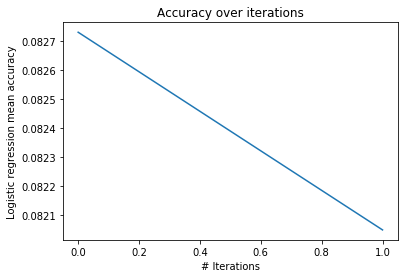

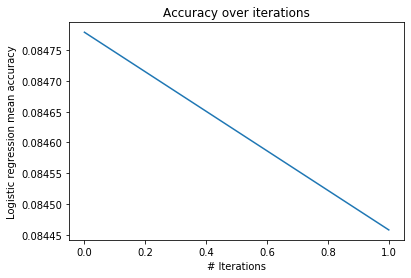

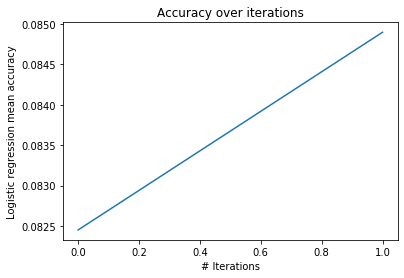

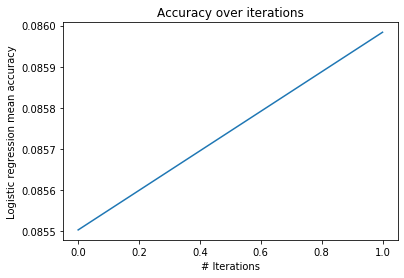

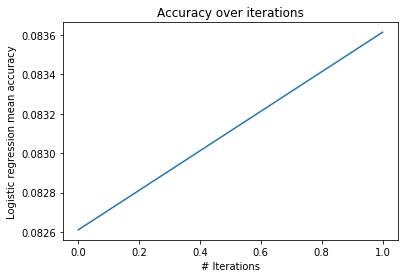

In [38]:
for id_, i in enumerate(mean_acc):
    plt.figure()
    plt.plot(i)
    plt.title('Accuracy over iterations')
    plt.xlabel('# Iterations')
    plt.ylabel('Logistic regression mean accuracy')
    plt.show()

In [39]:
for i in pred:
    print(classification_report(labels_t, i, target_names = classes))

             precision    recall  f1-score   support

  aeroplane       0.11      0.01      0.02      2075
    bicycle       0.07      0.03      0.04      2075
        bus       0.08      0.03      0.05      2075
        car       0.09      0.15      0.11      2075
      horse       0.13      0.00      0.01      2075
      knife       0.09      0.00      0.00      2075
 motorcycle       0.08      0.08      0.08      2075
     person       0.04      0.00      0.00      2075
      plant       0.09      0.03      0.05      2075
 skateboard       0.07      0.01      0.02      2075
      train       0.08      0.60      0.14      2075
      truck       0.08      0.02      0.03      2075

avg / total       0.08      0.08      0.05     24900

             precision    recall  f1-score   support

  aeroplane       0.09      0.01      0.02      2075
    bicycle       0.05      0.00      0.00      2075
        bus       0.08      0.44      0.14      2075
        car       0.09      0.21      0.12

In [40]:
majority_vote = np.maximum.reduce([pred[0], pred[1], pred[2], pred[3], pred[4]])

In [41]:
print(classification_report(labels_t, majority_vote, target_names = classes))

             precision    recall  f1-score   support

  aeroplane       0.08      0.00      0.00      2075
    bicycle       0.06      0.00      0.00      2075
        bus       0.09      0.03      0.04      2075
        car       0.09      0.07      0.08      2075
      horse       0.15      0.00      0.00      2075
      knife       0.06      0.00      0.00      2075
 motorcycle       0.09      0.14      0.11      2075
     person       0.08      0.00      0.01      2075
      plant       0.08      0.03      0.04      2075
 skateboard       0.09      0.04      0.06      2075
      train       0.08      0.64      0.14      2075
      truck       0.08      0.03      0.05      2075

avg / total       0.09      0.08      0.04     24900

